## Fairness Analysis of NamSor's Gender API Endpoint using Aequitas

Part I: Fairness of Gender API Endpoint by Gender and Ethnicity

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/compas_gender_predictions.csv")
df.head()

,Unnamed: 0,entity_id,first,last,sex,sex_pred,race,score,label_value
0,0,1,miguel,hernandez,Male,Male,Other,0.999286,1.0
1,1,3,kevon,dixon,Male,Male,African-American,0.956720,1.0
2,2,4,ed,philo,Male,Male,African-American,0.968813,1.0
3,3,5,marcu,brown,Male,Male,African-American,0.622665,1.0
4,4,6,bouthy,pierrelouis,Male,Male,Other,0.509131,1.0


In [3]:
# Non String columns will lead to problems later so we have to find out if there are any
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [4]:
# And delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,first,last,sex,sex_pred,race,score,label_value
0,1,miguel,hernandez,Male,Male,Other,0.999286,1.0
1,3,kevon,dixon,Male,Male,African-American,0.956720,1.0
2,4,ed,philo,Male,Male,African-American,0.968813,1.0
3,5,marcu,brown,Male,Male,African-American,0.622665,1.0
4,6,bouthy,pierrelouis,Male,Male,Other,0.509131,1.0


In [5]:
# we only want to look at gender here, since that is what we calculated label_value for
df = df.drop(['sex_pred', 'first', 'last'], axis=1) # if we don't drop the tables, Aequitas thinks these are attributes by which groups should be separated

In [6]:
df.shape

(7214, 5)

## Group Metrics

In [7]:
t = 0.8

In [8]:
f_pp = df[((df['sex'] == 'Female') & (df['score'] >= t))]
f_pp.count()

entity_id      1248
sex            1248
race           1248
score          1248
label_value    1248
dtype: int64

In [9]:
f_pn = df[((df['sex'] == 'Female') & (df['score'] < t))]
f_pn.count()

entity_id      147
sex            147
race           147
score          147
label_value    147
dtype: int64

In [10]:
f_p = df[((df['sex'] == 'Female') & (df['label_value'] == 1))]
f_p.count()

entity_id      1289
sex            1289
race           1289
score          1289
label_value    1289
dtype: int64

In [11]:
f_n = df[((df['sex'] == 'Female') & (df['label_value'] == 0))]
f_n.count()

entity_id      106
sex            106
race           106
score          106
label_value    106
dtype: int64

In [12]:
f_tn = df[((df['sex'] == 'Female') & (df['score'] < t) & (df['label_value'] == 0) )]
f_tn.count()

entity_id      43
sex            43
race           43
score          43
label_value    43
dtype: int64

In [13]:
f_tp = df[((df['sex'] == 'Female') & (df['score'] >= t) & (df['label_value'] == 1))]
f_tp.count()

entity_id      1185
sex            1185
race           1185
score          1185
label_value    1185
dtype: int64

In [14]:
f_fn = df[((df['sex'] == 'Female') & (df['score'] < t) & (df['label_value'] == 1))]
f_fn.count()

entity_id      104
sex            104
race           104
score          104
label_value    104
dtype: int64

In [15]:
f_fp = df[((df['sex'] == 'Female') & (df['score'] >= t) & (df['label_value'] == 0))]
f_fp.count()

entity_id      63
sex            63
race           63
score          63
label_value    63
dtype: int64

In [16]:
g = Group()
xtab, _ = g.get_crosstabs(df, attr_cols=["sex", "race"], score_thresholds= {'score': [t]})
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'score': [0.8]}


In [17]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,0.8_ore,706,sex,Female,147,1248,43,1185,63,104,1289,106,1395,7214
1,0,0.8_ore,706,sex,Male,559,5260,158,5072,188,401,5473,346,5819,7214
2,0,0.8_ore,706,race,African-American,502,3194,139,3041,153,363,3404,292,3696,7214
3,0,0.8_ore,706,race,Asian,7,25,1,24,1,6,30,2,32,7214
4,0,0.8_ore,706,race,Caucasian,90,2364,26,2290,74,64,2354,100,2454,7214
5,0,0.8_ore,706,race,Hispanic,28,609,11,603,6,17,620,17,637,7214
6,0,0.8_ore,706,race,Native American,1,17,1,16,1,0,16,2,18,7214
7,0,0.8_ore,706,race,Other,78,299,23,283,16,55,338,39,377,7214


In [18]:
# This looks very weird. See https://github.com/dssg/aequitas/issues/84
# To be continued ...

In [19]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.08,0.59,0.95,0.29,0.41,0.92,0.05,0.71,0.21,0.11,0.92
1,sex,Male,0.07,0.54,0.96,0.28,0.46,0.93,0.04,0.72,0.79,0.10,0.94
2,race,African-American,0.11,0.52,0.95,0.28,0.48,0.89,0.05,0.72,0.71,0.14,0.92
3,race,Asian,0.20,0.50,0.96,0.14,0.50,0.80,0.04,0.86,0.01,0.22,0.94
4,race,Caucasian,0.03,0.74,0.97,0.29,0.26,0.97,0.03,0.71,0.13,0.04,0.96
5,race,Hispanic,0.03,0.35,0.99,0.39,0.65,0.97,0.01,0.61,0.04,0.04,0.97
6,race,Native American,0.00,0.50,0.94,1.00,0.50,1.00,0.06,0.00,0.00,0.06,0.89
7,race,Other,0.16,0.41,0.95,0.29,0.59,0.84,0.05,0.71,0.11,0.21,0.90


### Visualize Group Metrics

In [20]:
aq_palette = sns.diverging_palette(225, 35, n=2)
aqp = Plot()

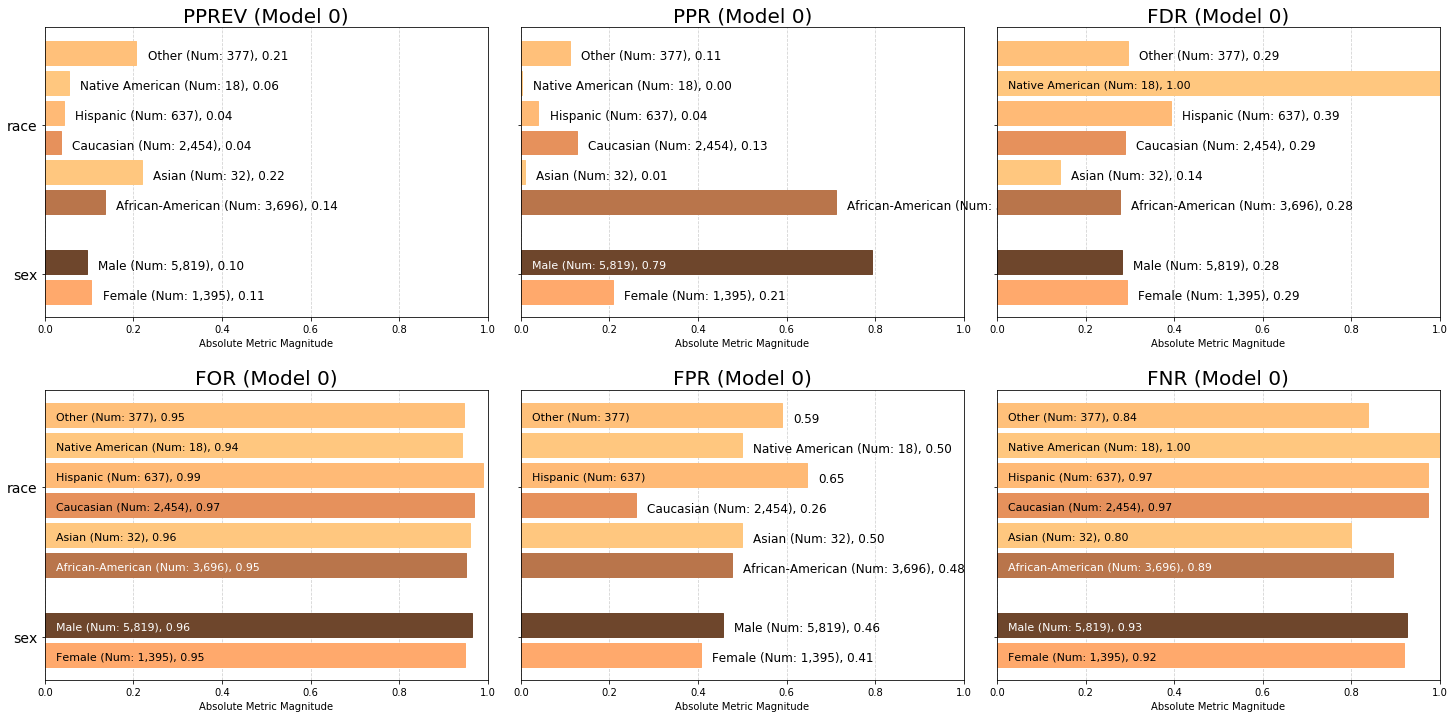

<Figure size 432x288 with 0 Axes>

In [21]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

## Disparities of Group Metrics

In [22]:
b = Bias()
df.head()

,entity_id,sex,race,score,label_value
0,1,Male,Other,0.999286,1.0
1,3,Male,African-American,0.956720,1.0
2,4,Male,African-American,0.968813,1.0
3,5,Male,African-American,0.622665,1.0
4,6,Male,Other,0.509131,1.0


#### Disparities calculated in relation to a user-specified group for each attribute

In [23]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'sex':'Male', 'race':'Caucasian'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=False)
bdf.style

get_disparity_predefined_group()


C:\Program_Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program_Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Program_Files\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Program_Files\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Program_Files\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,0.8_ore,706,sex,Female,0.0806827,0.59434,0.949519,0.292517,0.40566,0.919317,0.0504808,0.707483,147,1248,0.208215,0.105376,43,1185,63,104,1289,106,1395,7214,0.924014,0.0329857,0.0212057,1.03492,Male,0.0896838,0.992,Male,0.0653724,0.984714,Male,0.0653724,0.888345,Male,0.0896838,1.41239,Male,0.0653724,0.26297,Male,0.0212057,1.09693,Male,0.0212057,0.986242,Male,0.0896838,1.09384,Male,0.0896838,1.10119,Male,0.0653724
1,0,0.8_ore,706,sex,Male,0.0732688,0.543353,0.964259,0.282648,0.456647,0.926731,0.0357414,0.717352,559,5260,0.791785,0.0960646,158,5072,188,401,5473,346,5819,7214,0.94054,1,1,1,Male,1,1,Male,1,1,Male,1,1,Male,1,1,Male,1,1,Male,1,1,Male,1,1,Male,1,1,Male,1,1,Male,1
2,0,0.8_ore,706,race,African-American,0.106639,0.523973,0.952098,0.276892,0.476027,0.893361,0.0479023,0.723108,502,3194,0.711048,0.135823,139,3041,153,363,3404,292,3696,7214,0.920996,1.57457e-10,4.6305e-10,0.958474,Caucasian,0.972084,0.918328,Caucasian,6.55329e-11,0.982864,Caucasian,6.55329e-11,1.83087,Caucasian,0.972084,1.53028,Caucasian,6.55329e-11,5.57778,Caucasian,4.6305e-10,3.70343,Caucasian,4.6305e-10,1.01687,Caucasian,0.972084,0.708071,Caucasian,0.972084,3.92232,Caucasian,6.55329e-11
3,0,0.8_ore,706,race,Asian,0.2,0.5,0.96,0.142857,0.5,0.8,0.04,0.857143,7,25,0.00991501,0.21875,1,24,1,6,30,2,32,7214,0.9375,0.537904,0.20389,0.494505,Caucasian,nan,0.822358,Caucasian,0.516156,0.991022,Caucasian,0.516156,1.92308,Caucasian,nan,1.27784,Caucasian,0.516156,0.0777778,Caucasian,0.20389,5.96458,Caucasian,0.20389,1.20536,Caucasian,nan,0.675676,Caucasian,nan,7.35625,Caucasian,0.516156
4,0,0.8_ore,706,race,Caucasian,0.0271878,0.74,0.968697,0.288889,0.26,0.972812,0.0313029,0.711111,90,2364,0.127479,0.0366748,26,2290,74,64,2354,100,2454,7214,0.95925,1,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1,1,Caucasian,1
5,0,0.8_ore,706,race,Hispanic,0.0274194,0.352941,0.990148,0.392857,0.647059,0.972581,0.00985222,0.607143,28,609,0.0396601,0.043956,11,603,6,17,620,17,637,7214,0.973312,0.0975622,0.178497,1.35989,Caucasian,0.121215,0.999762,Caucasian,0.191142,1.02214,Caucasian,0.191142,2.48869,Caucasian,0.121215,0.314738,Caucasian,0.191142,0.311111,Caucasian,0.178497,1.19853,Caucasian,0.178497,0.853795,Caucasian,0.121215,0.476948,Caucasian,0.121215,1.00852,Caucasian,0.191142
6,0,0.8_ore,706,race,Native American,0,0.5,0.941176,1,0.5,1,0.0588235,0,1,17,0.00141643,0.0555556,1,16,1,0,16,2,18,7214,0.888889,0.134919,0.340603,3.46154,Caucasian,nan,1.02795,Caucasian,0.125818,0.97159,Caucasian,0.125818,1.92308,Caucasian,nan,1.87917,Caucasian,0.125818,0.0111111,Caucasian,0.340603,1.51481,Caucasian,0.340603,0,Caucasian,nan,0.675676,Caucasian,nan,0,Caucasian,0.125818
7,0,0.8_ore,706,race,Other,0.162722,0.410256,0.946488,0.294872,0.589744,0.837278,0.0535117,0.705128,78,299,0.110482,0.206897,23,283,16,55,338,39,377,7214,0.896552,0.000126348,5.09522e-08,1.02071,Caucasian,0.619316,0.860678,Caucasian,8.99021e-05,0.977074,Caucasian,8.99021e-05,2.26824,Caucasian,0.619316,1.70948,Caucasian,8.99021e-05,0.866667,Caucasian,5.09522e-08,5.64138,Caucasian,5.09522e-08,0.991587,Caucasian,0.619316,0.554401,Caucasian,0.619316,5.98511,Caucasian,8.99021e-05


In [24]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,sex,Female,1.03492,0.992,0.984714,0.888345,1.41239,0.26297,1.09693,0.986242,1.09384,1.10119,0.0329857,0.0212057,0.0896838,0.0653724,0.0653724,0.0896838,0.0653724,0.0212057,0.0212057,0.0896838,0.0896838,0.0653724
1,sex,Male,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,race,African-American,0.958474,0.918328,0.982864,1.83087,1.53028,5.57778,3.70343,1.01687,0.708071,3.92232,1.57457e-10,4.6305e-10,0.972084,6.55329e-11,6.55329e-11,0.972084,6.55329e-11,4.6305e-10,4.6305e-10,0.972084,0.972084,6.55329e-11
3,race,Asian,0.494505,0.822358,0.991022,1.92308,1.27784,0.0777778,5.96458,1.20536,0.675676,7.35625,0.537904,0.20389,nan,0.516156,0.516156,nan,0.516156,0.20389,0.20389,nan,nan,0.516156
4,race,Caucasian,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,race,Hispanic,1.35989,0.999762,1.02214,2.48869,0.314738,0.311111,1.19853,0.853795,0.476948,1.00852,0.0975622,0.178497,0.121215,0.191142,0.191142,0.121215,0.191142,0.178497,0.178497,0.121215,0.121215,0.191142
6,race,Native American,3.46154,1.02795,0.97159,1.92308,1.87917,0.0111111,1.51481,0,0.675676,0,0.134919,0.340603,nan,0.125818,0.125818,nan,0.125818,0.340603,0.340603,nan,nan,0.125818
7,race,Other,1.02071,0.860678,0.977074,2.26824,1.70948,0.866667,5.64138,0.991587,0.554401,5.98511,0.000126348,5.09522e-08,0.619316,8.99021e-05,8.99021e-05,0.619316,8.99021e-05,5.09522e-08,5.09522e-08,0.619316,0.619316,8.99021e-05


### Visualizing disparities

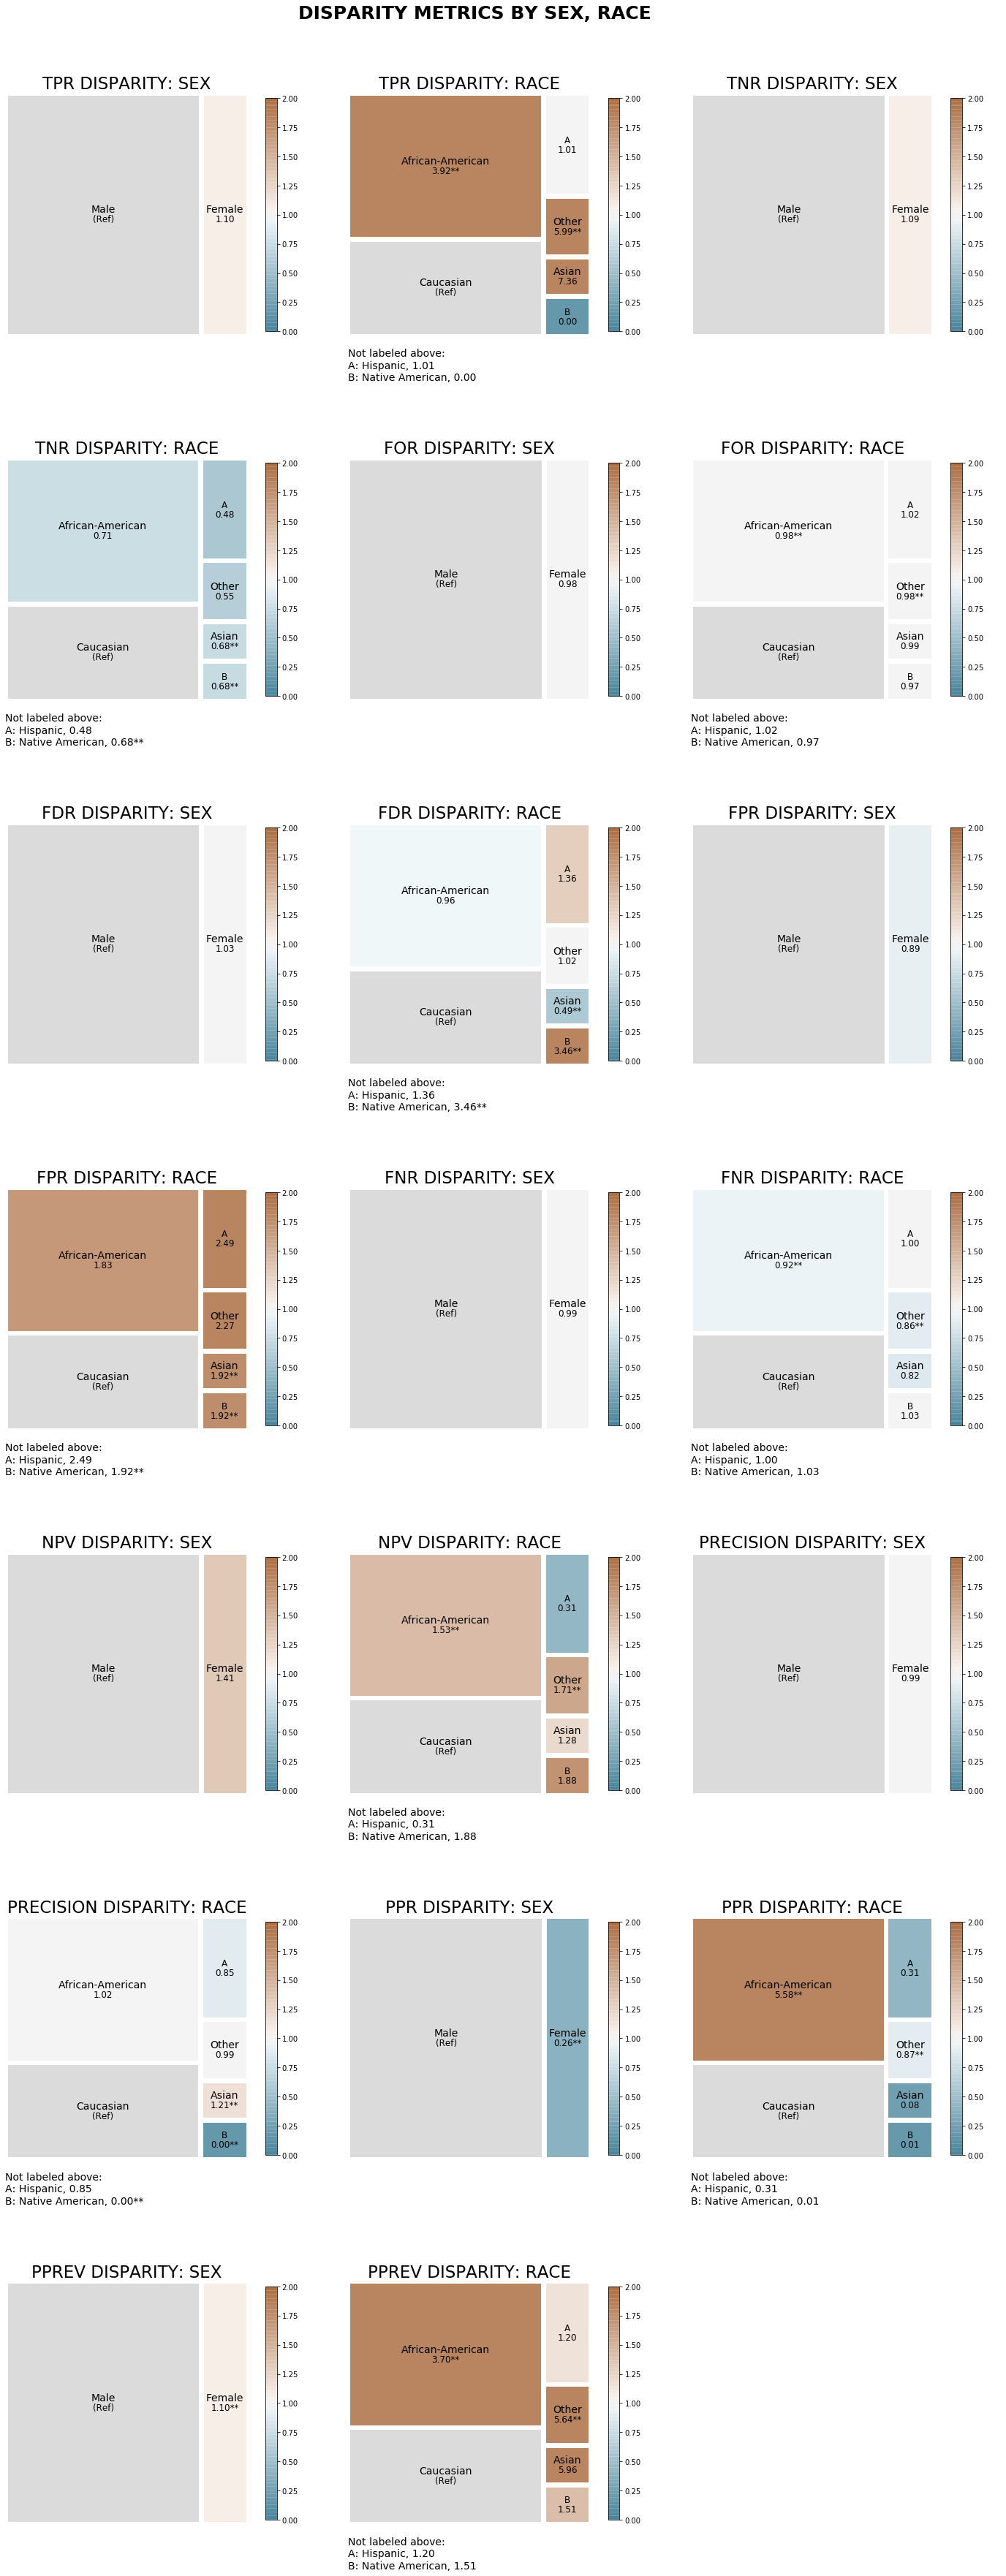

In [25]:
tm_capped = aqp.plot_disparity_all(bdf, attributes=['sex', 'race'], metrics = 'all', significance_alpha=0.05)

## Fairness Metrics

In [26]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [27]:
parity_detrminations = f.list_parities(fdf)

In [28]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,FOR Parity,TypeII Parity,Equalized Odds,FDR Parity,FNR Parity,Statistical Parity,Supervised Fairness,NPV Parity,TNR Parity,Unsupervised Fairness,TypeI Parity,FPR Parity,TPR Parity,Precision Parity,Impact Parity
0,sex,Female,0.0806827,0.59434,0.949519,0.292517,0.40566,0.919317,0.0504808,0.707483,0.208215,0.105376,0.924014,1.03492,0.992,0.984714,0.888345,1.41239,0.26297,1.09693,0.986242,1.09384,1.10119,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True
1,sex,Male,0.0732688,0.543353,0.964259,0.282648,0.456647,0.926731,0.0357414,0.717352,0.791785,0.0960646,0.94054,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,race,African-American,0.106639,0.523973,0.952098,0.276892,0.476027,0.893361,0.0479023,0.723108,0.711048,0.135823,0.920996,0.958474,0.918328,0.982864,1.83087,1.53028,5.57778,3.70343,1.01687,0.708071,3.92232,True,True,False,True,True,False,False,False,False,False,False,False,False,True,False
3,race,Asian,0.2,0.5,0.96,0.142857,0.5,0.8,0.04,0.857143,0.00991501,0.21875,0.9375,0.494505,0.822358,0.991022,1.92308,1.27784,0.0777778,5.96458,1.20536,0.675676,7.35625,True,True,False,False,True,False,False,False,False,False,False,False,False,True,False
4,race,Caucasian,0.0271878,0.74,0.968697,0.288889,0.26,0.972812,0.0313029,0.711111,0.127479,0.0366748,0.95925,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,race,Hispanic,0.0274194,0.352941,0.990148,0.392857,0.647059,0.972581,0.00985222,0.607143,0.0396601,0.043956,0.973312,1.35989,0.999762,1.02214,2.48869,0.314738,0.311111,1.19853,0.853795,0.476948,1.00852,True,True,False,False,True,False,False,False,False,False,False,False,True,True,True
6,race,Native American,0,0.5,0.941176,1,0.5,1,0.0588235,0,0.00141643,0.0555556,0.888889,3.46154,1.02795,0.97159,1.92308,1.87917,0.0111111,1.51481,0,0.675676,0,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False
7,race,Other,0.162722,0.410256,0.946488,0.294872,0.589744,0.837278,0.0535117,0.705128,0.110482,0.206897,0.896552,1.02071,0.860678,0.977074,2.26824,1.70948,0.866667,5.64138,0.991587,0.554401,5.98511,True,True,False,True,True,True,False,False,False,False,False,False,False,True,False


In [29]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,0.8_ore,race,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False
1,0,0.8_ore,sex,False,True,True,True,True,True,True,True,False,True,True,True,True,False,True


In [30]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### Visualize fairness

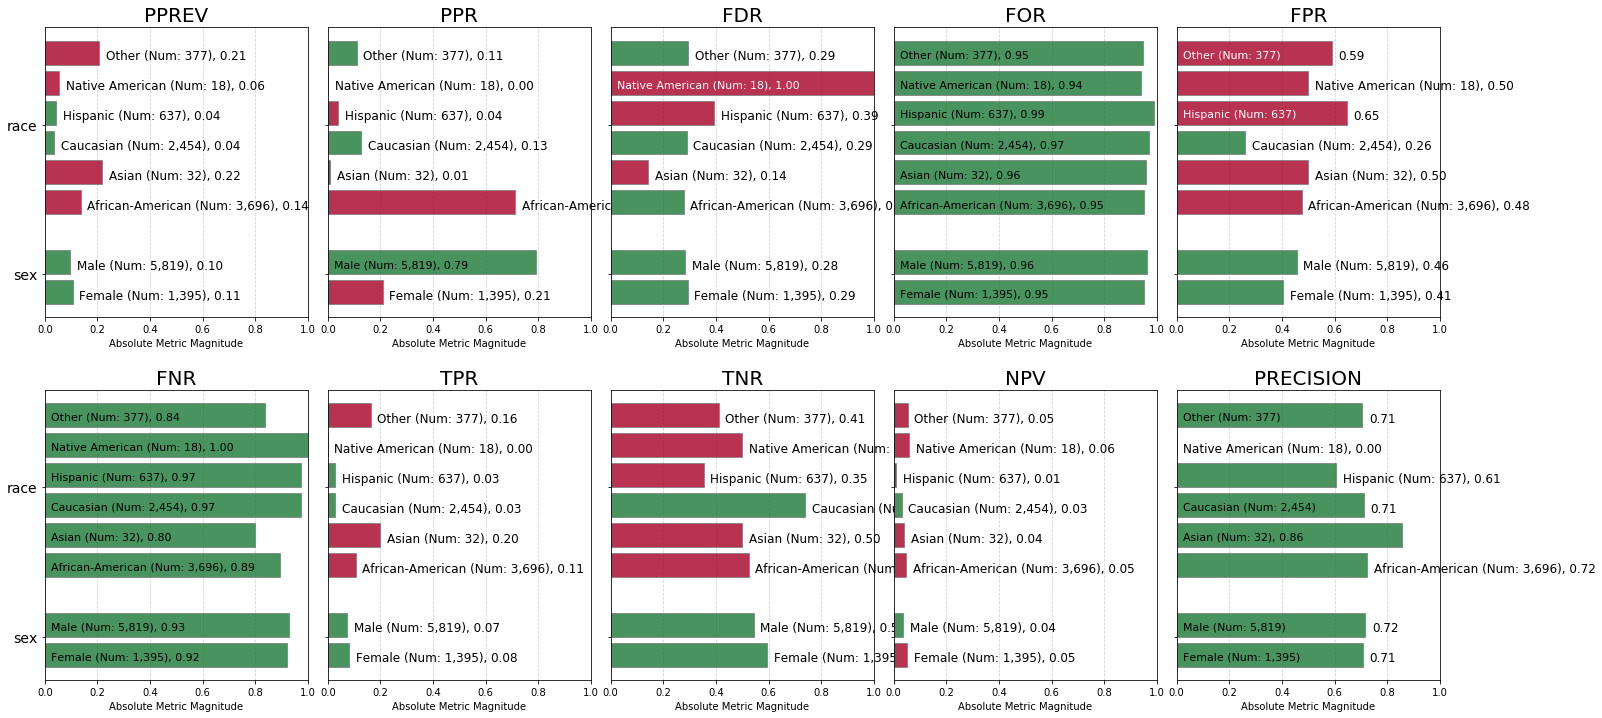

<Figure size 432x288 with 0 Axes>

In [31]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

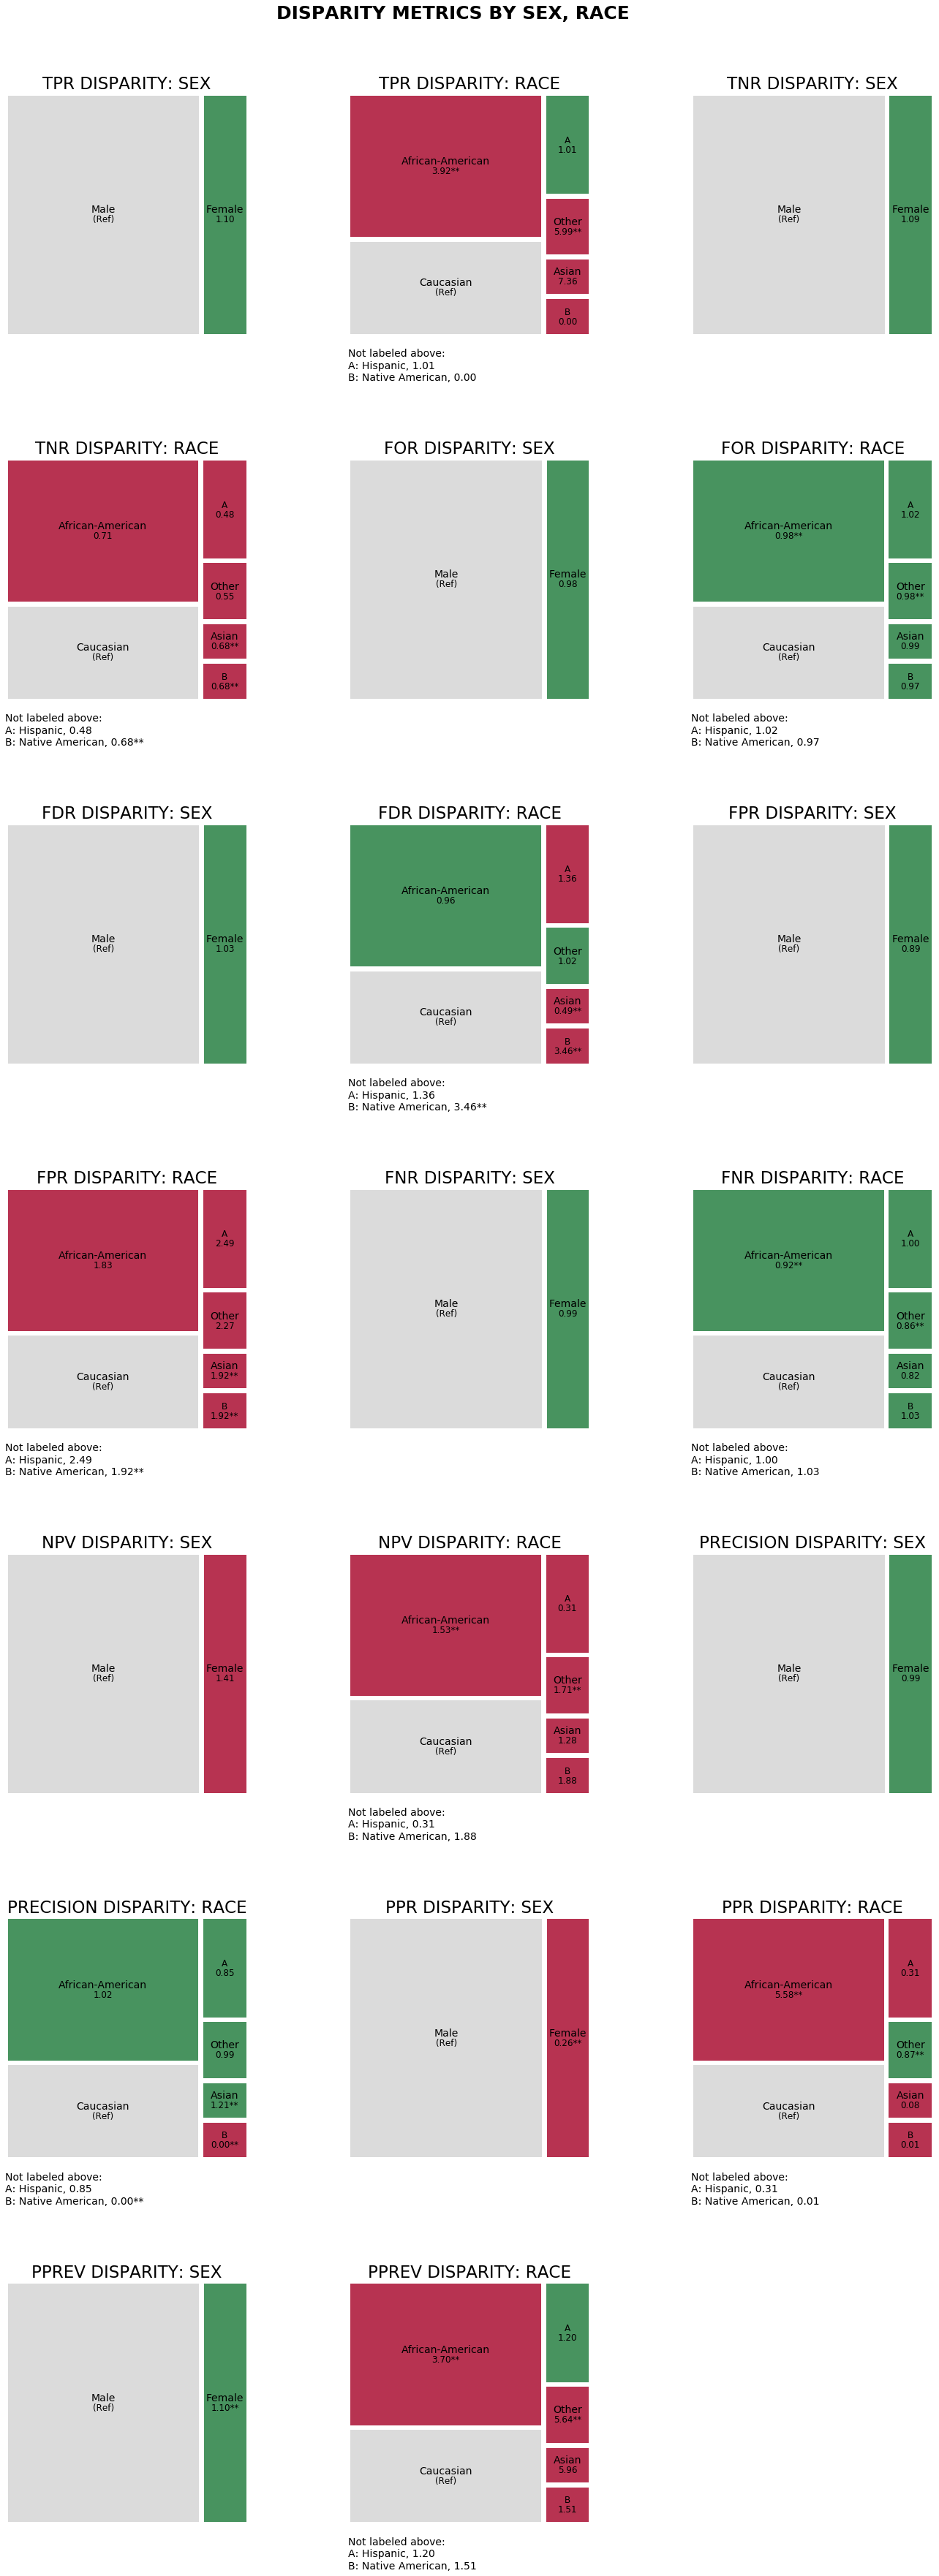

In [32]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['sex', 'race'], metrics='all', 
                                       significance_alpha=0.05)